In [230]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor


usd_ars_df = pd.read_csv('Datos históricos USD_ARS.csv', delimiter=',')
"Fecha","Último","Apertura","Máximo","Mínimo","Vol.","% var."
"04.11.2024","992,7500","989,7355","992,8412","986,9038","","0,30%"
"03.11.2024","989,7355","989,2032","989,8356","988,7034","","-0,03%"
"01.11.2024","990,0000","989,5000","990,0000","989,5000","","0,00%"
"31.10.2024","990,0000","989,0000","990,0000","989,0000","","0,15%"
"30.10.2024","988,5000","988,5000","989,2400","988,5000","","0,10%"
usd_arsb_df = pd.read_csv('Datos históricos USD_ARSB.csv', delimiter=',')
"Fecha","Último","Apertura","Máximo","Mínimo","Vol.","% var."
"01.11.2024","1.170,00","1.190,00","1.190,00","1.170,00","","0,00%"
"31.10.2024","1.170,00","1.180,00","1.180,00","1.170,00","","0,86%"
"30.10.2024","1.160,00","1.180,00","1.180,00","1.160,00","","-1,28%"
"29.10.2024","1.175,00","1.205,00","1.205,00","1.175,00","","-2,08%"
"28.10.2024","1.200,00","1.220,00","1.220,00","1.200,00","","-1,23%"
"25.10.2024","1.215,00","1.225,00","1.215,00","1.215,00","","1,67%"
"24.10.2024","1.195,00","1.215,00","1.215,00","1.195,00","","-2,05%"
temperatures_df = pd.read_csv('historico_temperaturas.csv', delimiter=',')
""" año,mes,máxima,mínima,media
1991,Enero,28.4,19.8,24.1
1991,Febrero,27.8,17.8,22.8
1991,Marzo,27.6,18.4,23
1991,Abril,22.4,13.6,18
1991,Mayo,20.7,12.2,16.45
1991,Junio,14.8,7.6,11.2
1991,Julio,14.8,6.7,10.75
1991,Agosto,17.1,9.3,13.2 """
#company_results_df = pd.read_csv('HISTORIAL_RESULTADOS_2.csv', delimiter=',')

# Leer el archivo de pedidos, para cada hoja
hojas = pd.ExcelFile('pedidos.xlsx')

# remove specified sheets if they exist
sheets_to_remove = ['ETIQUETA EQUIPO TERMINADO', 'ETIQUETAS PRODUCCION', 'ETIQUETA MONOFASICO', 'ETIQUETA TRIFASICO']

# concatenar todas las hojas
df = pd.concat([hojas.parse(hoja) for hoja in hojas.sheet_names if hoja not in sheets_to_remove])

# delete where null in Nº PEDIDO or Nº PEDIDO is not a number
df = df.dropna(subset=['Nº PEDIDO'])
#drop where n pedido is ''
df = df[df['Nº PEDIDO'] != '']
#values of Nº PEDIDO to int
df = df[~df['Nº PEDIDO'].astype(str).str.contains('b')]

df = df.drop(columns=['Unnamed: 4', 'EST. FINANCIERO', 'DEUDA $', 'DEUDA U$S', 'Unnamed: 15', 'F. MAIL', 'F. CLIENTE', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 16'])

# drop rows where all of 'F.PEDIDO', 'CLIENTE', 'VENDEDOR', 'EQUIPO' are null
df = df.dropna(subset=['F.PEDIDO', 'CLIENTE', 'VENDEDOR', 'EQUIPO'], how='all')

#drop where ENERGIA GLOBAL is in cliente
df = df[~df['CLIENTE'].str.contains('ENERGIA GLOBAL')]

print(df.shape)

(3464, 13)


In [231]:
df.columns

Index(['Nº PEDIDO', 'VENDEDOR', 'CLIENTE', 'EQUIPO', 'Q/E', 'OBSERVACIONES',
       'F.PEDIDO', 'N° TACTICA', 'ESTADO', 'F.TERMINADO', 'N° SERIE',
       'ALTERNADOR', 'Nº DE SERIE'],
      dtype='object')

In [232]:
# Ensure the 'F.PEDIDO' column exists
if 'F.PEDIDO' in df.columns:
	# Convert 'F.PEDIDO' to datetime, coerce errors
	df['F.PEDIDO'] = pd.to_datetime(df['F.PEDIDO'], errors='coerce')
	# Drop rows with invalid dates
	print(df.shape)
	df = df.dropna(subset=['F.PEDIDO'])
	print(df.shape)
	# Take only the month and year of the F.PEDIDO in new columns
	df['MES'] = df['F.PEDIDO'].dt.month
	df['AÑO'] = df['F.PEDIDO'].dt.year
else:
	print("Column 'F.PEDIDO' does not exist in the dataframe.")

print(df.head())
""" Nº PEDIDO   VENDEDOR                                       CLIENTE  \
0         0    NICOLAS                     AGUSJO SRL / JUAN ROVELLI   
1       186  FLORENCIA  CAMINO PARQUE DEL BUEN AIRE / FERRARI ENZO H   
2       198  FLORENCIA            LG CONSULTORES AMBIENTALES / DIEGO   
3       241    ESTEBAN                               SOFLEX / EMILIO   
4       277    ESTEBAN                               SOFLEX / EMILIO   

                  EQUIPO  Q/E       OBSERVACIONES   F.PEDIDO N° TACTICA  \
0  EG-GEN-T-20000-CG-TTA  1/1                 NaN 2021-08-03       5486   
1       EG-GEN-T-8000E-C  1/2                 NaN 2023-09-18       0179   
2  EG-GEN-M-10500-CG-TTA  1/1                 NaN 2023-09-26       6933   
3   EG-GEN-T-16000-C-TTA  1/2  MODIFICACIONES 911 2023-10-19       6971   
4   EG-GEN-T-16000-C-TTA  1/1  MODIFICACIONES 911 2023-12-04       7019   

      ESTADO          F.TERMINADO         N° SERIE ALTERNADOR Nº DE SERIE  \
0        NaN                  NaN              NaN        NaN         NaN   
1  TERMINADO  2023-09-22 00:00:00  GCBBH-1211438-F        NaN         NaN   
2  TERMINADO  2023-12-29 00:00:00  GCAMH-2116823-F        NaN         NaN   
3  TERMINADO  2023-11-07 00:00:00  GCAPH-2093400-F        NaN         NaN   
4  TERMINADO  2024-02-07 00:00:00  GCAPH-2096700-F        NaN         NaN   

   MES   AÑO  AÑO-MES  
0    8  2021  2021-08  
1    9  2023  2023-09  
2    9  2023  2023-09  
3   10  2023  2023-10  
4   12  2023  2023-12   """


(3464, 13)
(3446, 13)
  Nº PEDIDO   VENDEDOR                                       CLIENTE  \
0         0    NICOLAS                     AGUSJO SRL / JUAN ROVELLI   
1       186  FLORENCIA  CAMINO PARQUE DEL BUEN AIRE / FERRARI ENZO H   
2       198  FLORENCIA            LG CONSULTORES AMBIENTALES / DIEGO   
3       241    ESTEBAN                               SOFLEX / EMILIO   
4       277    ESTEBAN                               SOFLEX / EMILIO   

                  EQUIPO  Q/E       OBSERVACIONES   F.PEDIDO N° TACTICA  \
0  EG-GEN-T-20000-CG-TTA  1/1                 NaN 2021-08-03       5486   
1       EG-GEN-T-8000E-C  1/2                 NaN 2023-09-18       0179   
2  EG-GEN-M-10500-CG-TTA  1/1                 NaN 2023-09-26       6933   
3   EG-GEN-T-16000-C-TTA  1/2  MODIFICACIONES 911 2023-10-19       6971   
4   EG-GEN-T-16000-C-TTA  1/1  MODIFICACIONES 911 2023-12-04       7019   

      ESTADO          F.TERMINADO         N° SERIE ALTERNADOR Nº DE SERIE  \
0        NaN     

' Nº PEDIDO   VENDEDOR                                       CLIENTE  0         0    NICOLAS                     AGUSJO SRL / JUAN ROVELLI   \n1       186  FLORENCIA  CAMINO PARQUE DEL BUEN AIRE / FERRARI ENZO H   \n2       198  FLORENCIA            LG CONSULTORES AMBIENTALES / DIEGO   \n3       241    ESTEBAN                               SOFLEX / EMILIO   \n4       277    ESTEBAN                               SOFLEX / EMILIO   \n\n                  EQUIPO  Q/E       OBSERVACIONES   F.PEDIDO N° TACTICA  0  EG-GEN-T-20000-CG-TTA  1/1                 NaN 2021-08-03       5486   \n1       EG-GEN-T-8000E-C  1/2                 NaN 2023-09-18       0179   \n2  EG-GEN-M-10500-CG-TTA  1/1                 NaN 2023-09-26       6933   \n3   EG-GEN-T-16000-C-TTA  1/2  MODIFICACIONES 911 2023-10-19       6971   \n4   EG-GEN-T-16000-C-TTA  1/1  MODIFICACIONES 911 2023-12-04       7019   \n\n      ESTADO          F.TERMINADO         N° SERIE ALTERNADOR Nº DE SERIE  0        NaN                  NaN

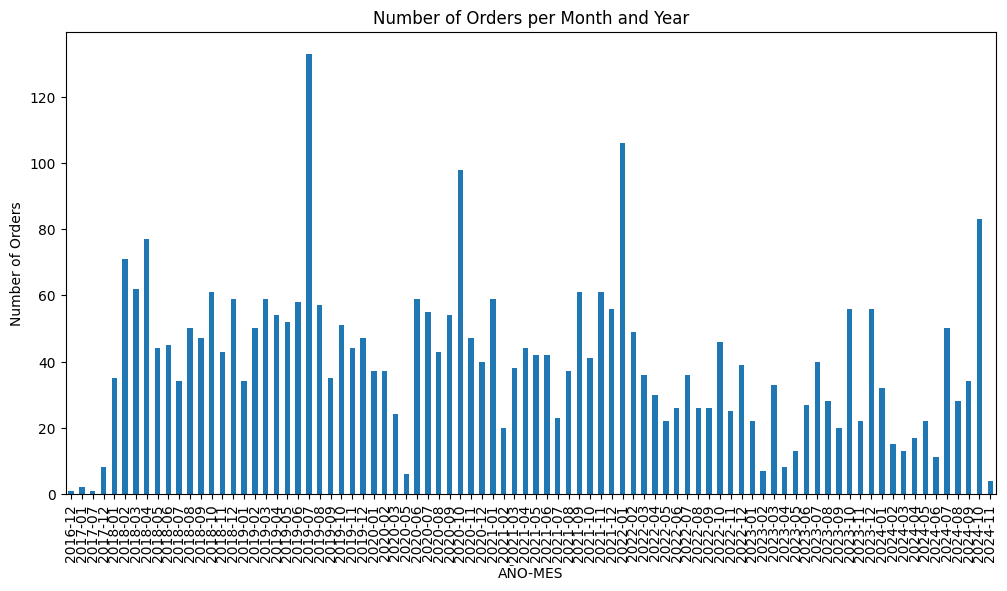

,index,AÑO-MES
0,2018-01,35
1,2018-02,71
2,2018-03,62
3,2018-04,77
4,2018-05,44


In [233]:
import matplotlib.pyplot as plt

# Create a new column 'AÑO-MES' for grouping
df['AÑO-MES'] = df['AÑO'].astype(str) + '-' + df['MES'].astype(str).str.zfill(2)
orders_df = df.copy()
# Plot the histogram
df['AÑO-MES'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.xlabel('AÑO-MES')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Month and Year')
plt.xticks(rotation=90)
plt.show()
# Save the dataframe to a CSV file
df.to_csv('orders_per_month_year.csv', index=False)
# Create a new dataframe with the count of orders per month and year
orders_per_month_year = df['AÑO-MES'].value_counts().sort_index().reset_index()

#drop where 2017 or 2016 is in AÑO-MES
orders_per_month_year = orders_per_month_year[~orders_per_month_year['index'].str.contains('2016') & ~orders_per_month_year['index'].str.contains('2017')].reset_index(drop=True)


# Display the new dataframe
orders_per_month_year.head()

In [234]:
orders_per_month_year.columns = ['AÑO-MES', 'N_PEDIDOS']
orders_per_month_year.head()

,AÑO-MES,N_PEDIDOS
0,2018-01,35
1,2018-02,71
2,2018-03,62
3,2018-04,77
4,2018-05,44


In [235]:
orders_df.head(

)

,Nº PEDIDO,VENDEDOR,CLIENTE,EQUIPO,Q/E,OBSERVACIONES,F.PEDIDO,N° TACTICA,ESTADO,F.TERMINADO,N° SERIE,ALTERNADOR,Nº DE SERIE,MES,AÑO,AÑO-MES
0,0,NICOLAS,AGUSJO SRL / JUAN ROVELLI,EG-GEN-T-20000-CG-TTA,1/1,NaN,2021-08-03,5486,NaN,NaN,NaN,NaN,NaN,8,2021,2021-08
1,186,FLORENCIA,CAMINO PARQUE DEL BUEN AIRE / FERRARI ENZO H,EG-GEN-T-8000E-C,1/2,NaN,2023-09-18,0179,TERMINADO,2023-09-22 00:00:00,GCBBH-1211438-F,NaN,NaN,9,2023,2023-09
2,198,FLORENCIA,LG CONSULTORES AMBIENTALES / DIEGO,EG-GEN-M-10500-CG-TTA,1/1,NaN,2023-09-26,6933,TERMINADO,2023-12-29 00:00:00,GCAMH-2116823-F,NaN,NaN,9,2023,2023-09
3,241,ESTEBAN,SOFLEX / EMILIO,EG-GEN-T-16000-C-TTA,1/2,MODIFICACIONES 911,2023-10-19,6971,TERMINADO,2023-11-07 00:00:00,GCAPH-2093400-F,NaN,NaN,10,2023,2023-10
4,277,ESTEBAN,SOFLEX / EMILIO,EG-GEN-T-16000-C-TTA,1/1,MODIFICACIONES 911,2023-12-04,7019,TERMINADO,2024-02-07 00:00:00,GCAPH-2096700-F,NaN,NaN,12,2023,2023-12


In [236]:
# Copy the dataframes to avoid incorrect manipulation of data
usd_ars_df_copy = usd_ars_df.copy()
usd_arsb_df_copy = usd_arsb_df.copy()
orders_df_copy = orders_df.copy()

# Ensure the 'Fecha' column in usd_ars_df_copy and usd_arsb_df_copy is in datetime format
usd_ars_df_copy['Fecha'] = pd.to_datetime(usd_ars_df_copy['Fecha'], format='%d.%m.%Y')
usd_arsb_df_copy['Fecha'] = pd.to_datetime(usd_arsb_df_copy['Fecha'], format='%d.%m.%Y')

# Replace commas with dots and remove periods in the thousands place, then convert 'Último' to numeric in usd_ars_df_copy
usd_ars_df_copy['Último'] = usd_ars_df_copy['Último'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.')
usd_ars_df_copy['% var.'] = usd_ars_df_copy['% var.'].astype(str).str.replace(',', '.')

# Replace commas with dots and remove periods in the thousands place, then convert 'Último' to numeric in usd_arsb_df_copy
usd_arsb_df_copy['Último'] = usd_arsb_df_copy['Último'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.')
usd_arsb_df_copy['% var.'] = usd_arsb_df_copy['% var.'].astype(str).str.replace(',', '.')

# Merge usd_ars_df_copy with orders_df_copy
orders_df_copy = orders_df_copy.merge(usd_ars_df_copy[['Fecha', 'Último', '% var.']], left_on='F.PEDIDO', right_on='Fecha', how='left')
orders_df_copy.rename(columns={'Último': 'USD_ARS_Oficial', '% var.': 'USD_ARS_Oficial_Rate'}, inplace=True)
if 'Fecha' in orders_df_copy.columns:
    orders_df_copy.drop(columns=['Fecha'], inplace=True)

# Merge usd_arsb_df_copy with orders_df_copy
orders_df_copy = orders_df_copy.merge(usd_arsb_df_copy[['Fecha', 'Último', '% var.']], left_on='F.PEDIDO', right_on='Fecha', how='left')
orders_df_copy.rename(columns={'Último': 'USD_ARS_Blue', '% var.': 'USD_ARS_Blue_Rate'}, inplace=True)

# Remove '%' and convert to float
orders_df_copy['USD_ARS_Oficial_Rate'] = orders_df_copy['USD_ARS_Oficial_Rate'].str.rstrip('%').astype(float) / 100
orders_df_copy['USD_ARS_Blue_Rate'] = orders_df_copy['USD_ARS_Blue_Rate'].str.rstrip('%').astype(float) / 100
orders_df_copy = orders_df_copy[(orders_df_copy['AÑO'] != 2016) & (orders_df_copy['AÑO'] != 2017)].reset_index(drop=True)

#drop 'N° SERIE','ALTERNADOR', 'Nº DE SERIE'
orders_df_copy = orders_df_copy.drop(columns=['N° SERIE', 'ALTERNADOR', 'Nº DE SERIE', 'N° TACTICA', 'Q/E'])

# Convert object columns to string
for col in orders_df_copy.select_dtypes(include=['object']).columns:
    orders_df_copy[col] = orders_df_copy[col].astype(str)
#corvert 'USD_ARS_Oficial': 'mean','USD_ARS_Blue': 'mean' to float
orders_df_copy['USD_ARS_Oficial'] = orders_df_copy['USD_ARS_Oficial'].astype(float)
orders_df_copy['USD_ARS_Blue'] = orders_df_copy['USD_ARS_Blue'].astype(float)

#create column TIEMPO de fabricacion en dias, terminado - pedido
orders_df_copy['F.TERMINADO'] = pd.to_datetime(orders_df_copy['F.TERMINADO'], errors='coerce')
orders_df_copy['F.PEDIDO'] = pd.to_datetime(orders_df_copy['F.PEDIDO'], errors='coerce')
orders_df_copy['TIEMPO_FABRICACION'] = (orders_df_copy['F.TERMINADO'] - orders_df_copy['F.PEDIDO']).dt.days

# Display the updated dataframe
orders_df_copy.head()


/var/folders/m9/2_1nwl_907v26kxr1jj5r__40000gn/T/ipykernel_50838/4018643836.py:44: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  orders_df_copy['F.TERMINADO'] = pd.to_datetime(orders_df_copy['F.TERMINADO'], errors='coerce')


,Nº PEDIDO,VENDEDOR,CLIENTE,EQUIPO,OBSERVACIONES,F.PEDIDO,ESTADO,F.TERMINADO,MES,AÑO,AÑO-MES,USD_ARS_Oficial,USD_ARS_Oficial_Rate,Fecha,USD_ARS_Blue,USD_ARS_Blue_Rate,TIEMPO_FABRICACION
0,0,NICOLAS,AGUSJO SRL / JUAN ROVELLI,EG-GEN-T-20000-CG-TTA,nan,2021-08-03,nan,NaT,8,2021,2021-08,96.80,0.0001,2021-08-03,179.5,0.0000,NaN
1,186,FLORENCIA,CAMINO PARQUE DEL BUEN AIRE / FERRARI ENZO H,EG-GEN-T-8000E-C,nan,2023-09-18,TERMINADO,2023-09-22,9,2023,2023-09,349.95,0.0008,2023-09-18,735.5,0.0110,4.0
2,198,FLORENCIA,LG CONSULTORES AMBIENTALES / DIEGO,EG-GEN-M-10500-CG-TTA,nan,2023-09-26,TERMINADO,2023-12-29,9,2023,2023-09,350.00,0.0000,2023-09-26,755.5,0.0175,94.0
3,241,ESTEBAN,SOFLEX / EMILIO,EG-GEN-T-16000-C-TTA,MODIFICACIONES 911,2023-10-19,TERMINADO,2023-11-07,10,2023,2023-10,349.95,-0.0003,2023-10-19,890.0,-0.0056,19.0
4,277,ESTEBAN,SOFLEX / EMILIO,EG-GEN-T-16000-C-TTA,MODIFICACIONES 911,2023-12-04,TERMINADO,2024-02-07,12,2023,2023-12,362.45,0.0049,2023-12-04,920.0,-0.0265,65.0


In [237]:
orders_df_copy.shape

(3434, 17)

In [238]:
if 'Fecha' in orders_df_copy.columns:
    orders_df_copy.drop(columns=['Fecha'], inplace=True)

# Calculate the average USD_ARS_Oficial, USD_ARS_Blue, and the amount of orders for each month
sales_per_month_df = orders_df_copy.groupby('AÑO-MES').agg({
    'USD_ARS_Oficial_Rate': 'mean',
    'USD_ARS_Blue_Rate': 'mean',
    'TIEMPO_FABRICACION': 'mean',
    'USD_ARS_Oficial': 'mean',
    'USD_ARS_Blue': 'mean',
    'Nº PEDIDO': 'count'
}).reset_index()

# Rename the 'Nº PEDIDO' column to 'N_PEDIDOS'
sales_per_month_df.rename(columns={'Nº PEDIDO': 'N_PEDIDOS'}, inplace=True)

#split AÑO-MES to AÑO and MES
sales_per_month_df['AÑO'] = sales_per_month_df['AÑO-MES'].str.split('-', expand=True)[0]
sales_per_month_df['MES'] = sales_per_month_df['AÑO-MES'].str.split('-', expand=True)[1]
#drop
sales_per_month_df = sales_per_month_df.drop(columns=['AÑO-MES'])

#add col temporada, 10-3 1, 4-9 0
sales_per_month_df['TEMPORADA'] = np.where((sales_per_month_df['MES'].astype(int) >= 4) & (sales_per_month_df['MES'].astype(int) < 9), 0, 1)

#replace non values with 20 in Tiempo fabricacion
sales_per_month_df['TIEMPO_FABRICACION'] = sales_per_month_df['TIEMPO_FABRICACION'].fillna(20)

#locate where TIEMPO_FABRICACION is null
sales_per_month_df[sales_per_month_df['TIEMPO_FABRICACION'].isnull()]


# Display the new dataframe
sales_per_month_df.head(20)

,USD_ARS_Oficial_Rate,USD_ARS_Blue_Rate,TIEMPO_FABRICACION,USD_ARS_Oficial,USD_ARS_Blue,N_PEDIDOS,AÑO,MES,TEMPORADA
0,0.002806,0.001389,115.000000,19.008929,19.614571,35,2018,01,1
1,0.005194,0.000658,75.729167,19.656725,19.953380,71,2018,02,1
2,0.000845,0.001203,31.651163,20.239800,20.669000,62,2018,03,1
3,0.000385,-0.001087,31.382979,20.226503,20.525915,77,2018,04,0
4,0.012173,0.018620,37.947368,23.400114,24.124545,44,2018,05,0
5,0.006471,0.006087,5.944444,26.144956,26.660222,45,2018,06,0
6,-0.006644,-0.001238,5.071429,27.705353,28.692353,34,2018,07,0
7,0.014026,0.018622,-16.105263,30.139650,30.962600,50,2018,08,0
8,0.005591,-0.004162,2.933333,38.711862,38.101702,47,2018,09,1
9,-0.001743,-0.002563,7.526316,36.912825,37.013333,61,2018,10,1


In [239]:
sales_per_month_df.columns

Index(['USD_ARS_Oficial_Rate', 'USD_ARS_Blue_Rate', 'TIEMPO_FABRICACION',
       'USD_ARS_Oficial', 'USD_ARS_Blue', 'N_PEDIDOS', 'AÑO', 'MES',
       'TEMPORADA'],
      dtype='object')

In [240]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# split the train+validation set into train and validation sets
train_df, validation_df = train_test_split(sales_per_month_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {validation_df.shape}")
# Define the features and target variable
X = train_df[['AÑO', 'MES', 'TIEMPO_FABRICACION']]
y = train_df['N_PEDIDOS']

# Initialize the models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

""" 
# Perform KFold cross-validation for Linear Regression
lr_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')
print(f"Linear Regression R^2 scores: {lr_scores}")
print(f"Linear Regression mean R^2 score: {np.mean(lr_scores)}")

# Perform KFold cross-validation for Random Forest
rf_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
print(f"Random Forest R^2 scores: {rf_scores}")
print(f"Random Forest mean R^2 score: {np.mean(rf_scores)}")

# Choose the best model based on mean R^2 score
best_model = rf if np.mean(rf_scores) > np.mean(lr_scores) else lr
print(f"Best model: {'Random Forest' if best_model == rf else 'Linear Regression'}")

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search.fit(X, y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best score
print("Best R² Score:", grid_search.best_score_)

# Fit the best model on the entire training set
best_model.fit(X, y)

# Test the best model on the validation set
X_val = validation_df[['AÑO', 'MES']]
y_val = validation_df['N_PEDIDOS']
y_pred = best_model.predict(X_val)

# Calculate and print the performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Validation MSE: {mse}")
print(f"Validation R^2: {r2}") """

# Fit the best model on the entire training set
best_model.fit(X, y)

# Test the best model on the validation set
X_val = validation_df[['AÑO', 'MES', 'TIEMPO_FABRICACION']]
y_val = validation_df['N_PEDIDOS']
y_pred = best_model.predict(X_val)

# Define the parameter grid for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False]
}

# Set up Grid Search for Linear Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr,
                              cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search_lr.fit(X, y)

# Best parameters
print("Best Parameters for Linear Regression:", grid_search_lr.best_params_)

# Best score
print("Best R² Score for Linear Regression:", grid_search_lr.best_score_)

# Fit the best model on the entire training set
best_model_lr = grid_search_lr.best_estimator_
best_model_lr.fit(X, y)

# Test the best model on the validation set
y_pred_lr = best_model_lr.predict(X_val)

# Calculate and print the performance metrics
mse_lr = mean_squared_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)
print(f"Validation MSE for Linear Regression: {mse_lr}")
print(f"Validation R^2 for Linear Regression: {r2_lr}")

Train set size: (61, 9)
Validation set size: (21, 9)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
Best Parameters for Linear Regression: {'fit_intercept': True}
Best R² Score 